## Use DiffNet to create FEP network plan based on ML PD predictions

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.dpi']= 100
from tqdm.notebook import tqdm

In [2]:
import networkx as nx
import numpy as np
from cvxopt import matrix

import sys
sys.path.append("DiffNet")
import diffnet as dn
import graph as gph
from netbfe import *

import glob
import csv
import pandas as pd 
import pickle
import itertools
import matplotlib.image as mpimg
from numpy.lib.stride_tricks import as_strided

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFMCS, AllChem, rdmolfiles, Descriptors, rdchem, rdMolDescriptors
from rdkit.Chem.AtomPairs import Pairs

import mordred
from mordred import Calculator, descriptors

In [4]:
import sklearn
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import metrics
from scipy import stats


## Train RF ensemble 

In [5]:
quints_fps = pd.read_csv("output/quints_fps.csv", header=None)
quints_infos = pd.read_csv("output/quints_infos.csv", names=["set", "pertname", "pertsmarts", "num_ha", "sem"])

quints_whole_df = pd.concat([quints_infos, quints_fps], axis=1)

# drop faulty perturbations (n=66) that required sanitisation pre simulation. FE wrong because of atom mapping mistakes.
exclude_perts = [pert[0] for pert in pd.read_csv("to_do_sims/mapping_mismatches.csv", header=None).values.tolist()]

# extend list with inverse perts, we want to remove those as well.
inv_perts_to_exlude = []
for pert in exclude_perts:
    inv_perts_to_exlude.append(pert.split("~")[1]+"~"+pert.split("~")[0]) 
for pert in inv_perts_to_exlude:
    exclude_perts.append(pert)

quints_whole_df = quints_whole_df[~quints_whole_df['pertname'].isin(exclude_perts)]


In [6]:
# drop NaN columns (happens with molprop generation where (error) strings can't be subtracted)
quints_whole_df = quints_whole_df.dropna(axis=1)

# drop rows where SEM == 0.0. It seems some very large perturbations get this value too, so makes training noisy.
quints_whole_df = quints_whole_df[quints_whole_df["sem"] > 0.0001]

# drop columns where all values are 0.
quints_whole_df = quints_whole_df.loc[:, (quints_whole_df != 0).any(axis=0)]

# TMP DROP DUPLICATES --> should be fewer duplicates when we move up to more features.
quints_whole_df = quints_whole_df.drop_duplicates(subset=quints_whole_df.columns.difference(['sem','set','pertname','pertsmarts']))

In [7]:
### TMP DISCRETIZE BY STRATIFICATION:
n_bins=10

binned_sem = pd.qcut(quints_whole_df["sem"], n_bins, labels=False)
bin_means = []
quints_whole_df["sem_bin"] = binned_sem
print("Bin, Min, Max, Volume")
for n_bin, df_group in quints_whole_df.groupby(by="sem_bin"):
    print(n_bin, round(min(df_group["sem"].values), 2), round(max(df_group["sem"].values), 2), len(df_group))
    bin_means.append(np.mean(df_group["sem"].values))

Bin, Min, Max, Volume
(0, 0.01, 0.05, 328)
(1, 0.05, 0.07, 326)
(2, 0.07, 0.09, 326)
(3, 0.09, 0.11, 325)
(4, 0.11, 0.13, 328)
(5, 0.13, 0.16, 326)
(6, 0.16, 0.2, 326)
(7, 0.2, 0.3, 326)
(8, 0.3, 0.64, 326)
(9, 0.64, 26.33, 326)


In [8]:
quints_fps = quints_whole_df.drop(["set", "pertname", "pertsmarts", "num_ha", "sem", "sem_bin"], axis=1)
quints_fps = quints_fps.values
quints_infos = quints_whole_df[["set", "pertname", "pertsmarts", "num_ha", "sem", "sem_bin"]]

In [9]:
def takeSubset(indices, quints_whole_df):
    """Take a selection of a dataframe using indices"""
    subset = quints_whole_df.iloc[indices]
    
    return subset

def takeInfo(perts_df):
    """from an input dataframe, return arrays of fingerprints and SEMs"""
    sems = perts_df[["sem_bin", "sem"]].values
    
    # fps is a bit more involved. Remove everything but the FP columns, return as 2d array.
    fps_df = perts_df.drop(["set", "pertname", "pertsmarts", "num_ha", "sem", "sem_bin"], axis=1)
    fps = fps_df.values

    return fps, sems, fps_df.columns.values

In [10]:
def preProcessSet(train):
    """standardises and reduces dimensionality to 95% VE; returns arrays"""
    
    #### fit the scaler on training set.
    scaler = preprocessing.StandardScaler()
    train_scaled = scaler.fit_transform(train)
    
   
    #### fit PCA on training set with 95% variance explained.
    pca = PCA(n_components=0.95)
    train_preprocessed = pca.fit_transform(train_scaled)
    
    
    return train_preprocessed, scaler, pca

In [11]:
## TMP RANDOM SPLIT INSTEAD OF TSNE SPLIT
from sklearn.model_selection import train_test_split
whole_set, whole_set_sem_bins, column_indices_to_keep = takeInfo(takeSubset(np.array(range(len(quints_whole_df))), quints_whole_df))

# preprocess.
whole_set, scaler, pca = preProcessSet(whole_set)

# split
split = 0.2
train_set, test_set1, train_sems, upper_test_sems = train_test_split(whole_set, whole_set_sem_bins, test_size=split, random_state=42)

# save scaler and pca so that we can apply to test set.
pickle.dump(scaler, open("output/scaler.pkl", 'wb'))
pickle.dump(pca, open("output/pca.pkl", 'wb'))

# adjust label arrays such that we train on classes, but keep the actual SEM values for later.
train_sems_values = train_sems[:,1]
train_sems = train_sems[:,0]

upper_test_sems_values = upper_test_sems[:,1]
upper_test_sems = upper_test_sems[:,0]

n_classes = len(set(train_sems))

In [31]:
grid_predictions = None
grid_predictions = np.empty((len(test_set1),n_classes))
for i in tqdm(range(10)):
    hyperparams={'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1200}
                            
    forest = RandomForestClassifier(**hyperparams)
    forest.fit(np.array(train_set), np.array(train_sems))
    predicted_probas = forest.predict_proba(test_set1) 
    grid_predictions += predicted_probas

    pickle.dump(forest, open("output/rf_{}.pkl".format(i), 'wb'))

  0%|          | 0/10 [00:00<?, ?it/s]

Acc: 0.13
Tau: 0.13


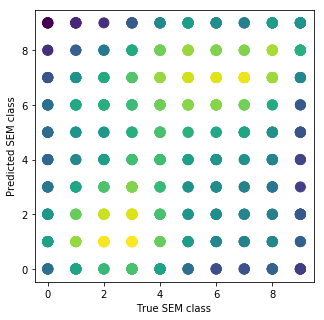

In [32]:
# Plot validation for the training.
model_preds = [np.argmax(pred) for pred in grid_predictions]
print "Acc:", round(metrics.accuracy_score(upper_test_sems, model_preds), 2)
print "Tau:", round(stats.kendalltau(upper_test_sems, model_preds)[0], 2)
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([upper_test_sems, model_preds])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(upper_test_sems, model_preds, c=z, s=100, edgecolor=None)
plt.xlabel("True SEM class")
plt.ylabel("Predicted SEM class")
plt.show()

### Load Loeffler18 set and featurise

In [33]:
mols = [ rdmolfiles.MolFromPDBFile(mol) for mol in glob.glob("TESTSETS/loeffler18/LIGANDS/*") ]
# sanitise.
for mol in mols: 
    Chem.SanitizeMol(mol)

mol_names = [ molpath.split("/")[-1].split(".pdb")[0] for molpath in glob.glob("TESTSETS/loeffler18/LIGANDS/*") ]

In [34]:
# load scaler and pca from trainingset protocol.
scaler = pickle.load(open("output/scaler.pkl", 'rb'))
pca = pickle.load(open("output/pca.pkl", 'rb'))

In [35]:
# get the featuriser.
descriptors_raw = open("./used_descriptors.txt", "r")
descriptors_raw_list = [line.split("\r") for line in descriptors_raw.readlines()]
descriptors_list = [desc[0] for desc in descriptors_raw_list]

calc = Calculator(descriptors, ignore_3D=False)  # register all descriptors
calc.descriptors = [d for d in calc.descriptors if str(d) in descriptors_list]  # re-register subset of descriptors


In [36]:
molprops_per_lig = [ np.array(calc(mol)) for mol in mols ]
molprops_per_lig_d = dict(zip(mol_names, molprops_per_lig))


In [37]:
# load all random forest models.
rf_models = []
for model_path in glob.glob("output/rf_*.pkl"):
    rf_models.append(pickle.load(open(model_path, 'rb')))

In [38]:
# make all possible perturbations (i.e. combinations).
preds = []
for liga, ligb in tqdm(list(itertools.combinations(mol_names, 2))):
    
    
    
    # compute features.
    pert = liga+"~"+ligb    

    dFP = []
    for lig1_prop, lig2_prop in zip(molprops_per_lig_d[liga], molprops_per_lig_d[ligb]):
        try:
            dFP.append(lig2_prop - lig1_prop)
        except TypeError:
            # when NaN, just append 0, i.e. no change.
            dFP.append(0)
    # multiple columns were excluded from our training set data, mostly null and NaN columns. Remove the 
    # same columns from this test point.
    dFP_clean = np.array(dFP)[column_indices_to_keep.astype(int)]
        
    # when NaN, just append 0, i.e. no change.
    dFP_clean = np.nan_to_num(dFP_clean)

    dFP_scaled = scaler.transform(dFP_clean.reshape(1, -1))
    dFP_prepped = pca.transform(dFP_scaled)
   




    # now make SEM predictions by the ensemble.
    model_preds = np.zeros(shape=(1, n_classes))
    
    for model in rf_models:
        model_preds += model.predict_proba(dFP_prepped)
        
    # append prediction to list of predictions. Could implement alternative function here, 
    # e.g. (weighted) mean class pred.
    
    preds.append(np.argmax(model_preds))    


  0%|          | 0/45 [00:00<?, ?it/s]

In [39]:
# make an empty dataframe.
pred_mtx = pd.DataFrame(columns=mol_names, index=mol_names)

for pred, (liga, ligb) in zip(preds, list(itertools.combinations(mol_names, 2))):
    # add value to all predictions such that we don't end up with zeroes in matrix (breaks CVXOPT)
    pred += 1
    
    # invert value because DiffNet high values are desirable edges. Scale to more readable format.
    pred = 1.0/pred*20

    # fill matrix with predicted SEMs.
    pred_mtx.loc[[liga], [ligb]] = pred
    pred_mtx.loc[[ligb], [liga]] = pred
pred_mtx = pred_mtx.replace(np.nan, np.inf)
pred_mtx       

,toluene,2-methylindole,ethane,2-cyclopentanylindole,methanol,7-cyclopentanylindole,ethanol,methane,2-methylfuran,neopentane
toluene,inf,2.222222,2.500000,2.222222,2.500000,2.222222,2.500000,2.500000,2.500000,2.500000
2-methylindole,2.222222,inf,2.222222,2.222222,2.222222,2.222222,2.222222,2.222222,2.500000,2.222222
ethane,2.500000,2.222222,inf,2.222222,20.000000,2.222222,20.000000,6.666667,2.222222,3.333333
2-cyclopentanylindole,2.222222,2.222222,2.222222,inf,2.222222,10.000000,2.222222,2.222222,2.222222,2.222222
methanol,2.500000,2.222222,20.000000,2.222222,inf,2.222222,5.000000,6.666667,2.222222,3.333333
7-cyclopentanylindole,2.222222,2.222222,2.222222,10.000000,2.222222,inf,2.222222,2.222222,2.222222,2.222222
ethanol,2.500000,2.222222,20.000000,2.222222,5.000000,2.222222,inf,6.666667,2.500000,3.333333
methane,2.500000,2.222222,6.666667,2.222222,6.666667,2.222222,6.666667,inf,2.222222,2.500000
2-methylfuran,2.500000,2.500000,2.222222,2.222222,2.222222,2.222222,2.500000,2.222222,inf,2.222222
neopentane,2.500000,2.222222,3.333333,2.222222,3.333333,2.222222,3.333333,2.500000,2.222222,inf


### Load numpy matrix for Loeffler18 set, run DiffNet

In [40]:
sij = np.array(pred_mtx)

In [41]:
# load ligand images + the order they appear in sij:
path_to_ligand_imgs = "TESTSETS/loeffler18/work/mol_imgs/"
path_to_ligand_idx = "TESTSETS/loeffler18/work/mol_imgs/ligand_index.csv"

ligand_order = []
with open(path_to_ligand_idx, "r") as f:
    reader = csv.reader(f)
    for row in reader:
        ligand_order.append(row[0])
        
lig_images_dict = {}
# for each ligand, read in the mol image and build dict:
for ligand in ligand_order:
    lig_img = mpimg.imread(path_to_ligand_imgs+ligand+".png")
    lig_images_dict[ligand] = lig_img



In [42]:
def draw_diffnet_graph( g, lig_imgs, ligand_order, pos=None, ax=None, fig=None,
                        widthscale=None, nodescale=2.5, node_color=None, molscale=None, max_sampling=None,
                        origins=['O']):
    '''
    Draw a graph representing the difference network.
    
    Args:
    g: nx.Graph - the graph representing the difference network.
    pos: Kx2 numpy array or dict - the coordinates to place the nodes 
    in the graph. If numpy array, pos[i] is the coordinates for node i,
    excluding origin.  If dict, pos[i] is the coordinate of node i, including
    origin. If None, use a spring layout.
    Returns:
    pos: dict - pos[i] gives the positions of the node i.
    '''
    K = g.number_of_nodes() - len(origins)

    if isinstance( pos, np.ndarray):
        mypos = dict( [(i, pos[i]) for i in xrange(K)])
        if (len(pos) == K):
            for d, o in enumerate(origins):
                mypos.update( {o : (-1.0*d, -1.0*d)})
        else:
            for d, o in enumerate(origins):
                mypos.update( {o : pos[K+d]})
    elif type( pos) == dict:
        mypos = pos
    elif pos == "custom":
        #mypos = nx.nx_agraph.graphviz_layout(g, prog="neato")
        mypos = nx.circular_layout( g)
    else:
        mypos = nx.spring_layout( g)
    
    node_size = nodescale*K
    if node_color is None:
        node_color = 'red'
    nx.draw_networkx_nodes( g, mypos, nodelist=range(K), 
                            node_size=node_size,
                            node_color=node_color,
                            ax=ax, alpha=1,
                          )
#     nodeO = nx.draw_networkx_nodes( g, mypos, nodelist=origins,
#                                     node_size=node_size*2,
#                                     node_color='#FFFFFF',
#                                     width=2.,
#                                     ax=ax)
#     if node_color is None or len(node_color)<=K:
#         nodeO.set_edgecolor( 'red')
#     else:
#         nodeO.set_edgecolor( node_color[K:])

    if widthscale is None:
        widthscale = 5.*K

    weights = np.array( [ w for u, v, w in list(g.edges( data='weight')) ])
    weights[weights<0] = 0 # Set negative numbers to 0.
    

    if max_sampling:
        
        # figure out highest weights:
        sorted_weights = np.sort(weights)[::-1]
        sampling_checker = num_top_edges_to_keep = 0

        # keep adding highest weights until max_sampling threshold is reached
        for weight in sorted_weights:
            sampling_checker += weight
            
            # when threshold is reached, output the weight threshold
            if sampling_checker >= max_sampling:
                weight_threshold = weight
                break
                
        # replace every weight below threshold with nan to hide edges:
        weights[weights<weight_threshold] = np.nan 
    
    
    width = weights*widthscale
    nx.draw_networkx_edges( g, mypos, 
                            width=width,
                            ax=ax)
    
    
    # overlay molecular representations onto nodes:
    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform
    imsize=molscale
    for n, lig_name in zip(g.nodes(), ligand_order):

        img = lig_imgs[lig_name]
        (x,y) = mypos[n]
        xx,yy = trans((x,y)) # figure coordinates
        xa,ya = trans2((xx,yy)) # axes coordinates
        

        # add mol image:
        a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ], zorder=100)
        a.imshow(img)
        

        a.axis('off')
    
    
    return mypos

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.0000e+02  2e+03  4e-01  9e+00  1e+00
 1:  2.9833e+00  1.8198e+00  2e+01  5e-03  1e-01  1e-02
 2:  1.0414e+00  9.6613e-01  2e+00  3e-04  7e-03  1e-03
 3:  6.6637e-01  6.1706e-01  1e+00  2e-04  5e-03  2e-03
 4:  5.2348e-01  5.0126e-01  8e-01  1e-04  2e-03  2e-03
 5:  4.1727e-01  4.0974e-01  3e-01  4e-05  8e-04  1e-03
 6:  3.5037e-01  3.4752e-01  2e-01  2e-05  3e-04  8e-04
 7:  3.3287e-01  3.3193e-01  6e-02  5e-06  1e-04  3e-04
 8:  3.1949e-01  3.1943e-01  4e-03  4e-07  8e-06  2e-05
 9:  3.1877e-01  3.1876e-01  7e-04  6e-08  1e-06  4e-06
10:  3.1866e-01  3.1865e-01  7e-05  6e-09  1e-07  4e-07
11:  3.1864e-01  3.1864e-01  3e-06  3e-10  5e-09  2e-08
12:  3.1864e-01  3.1864e-01  1e-07  1e-11  2e-10  8e-10
Optimal solution found.


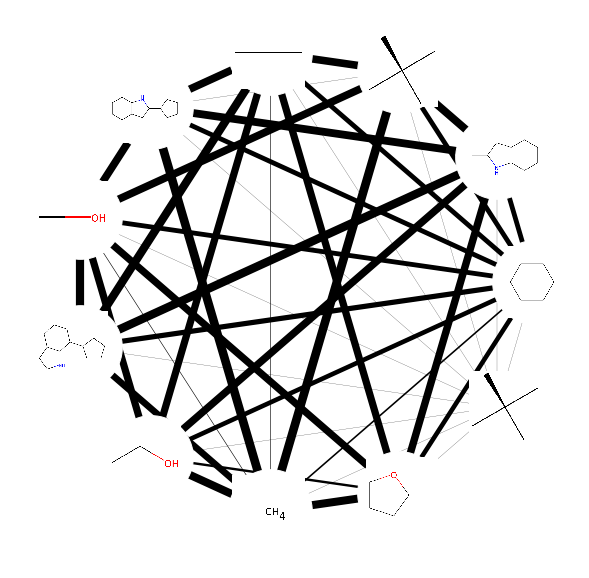

In [43]:
sij = matrix(sij)

        
N=1000
integer_n=True

n = networkBFEalloc( sij, N)
if integer_n:
    nint = round_to_integers( n)
    n = matrix( nint[:], n.size, tc='d')
    
G = gph.diffnet_to_graph( n)
fig, ax = plt.subplots( figsize=(10, 10))
draw_diffnet_graph( G, lig_images_dict, ligand_order, 
                   pos="custom", ax=ax, fig=fig, widthscale=200./N, 
                   nodescale=700, molscale=0.1, node_color="white")
ax.set_aspect( 1)
ax.axis( 'off')

plt.savefig("TESTSETS/loeffler18/diff_network.png", dpi=300)
plt.show()
